In [1]:
import os
marks_paragraphs = []
for root, dirs, files in os.walk("text"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                paragraphs = input.read().split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            #print(paragraphs[0])
            marks_paragraphs.extend(paragraphs)
            




text/com.txt


In [2]:
import os
marks_sentences = []
for root, dirs, files in os.walk("text"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().split(".")   #. denotes end of sentence
            marks_sentences.extend(sentences)
            
print(len(marks_sentences))
print(marks_sentences[10])

text/com.txt
424


The discovery of America, the rounding of the Cape, opened up fresh
ground for the rising bourgeoisie


In [3]:
import pandas as pd
marks_df = pd.DataFrame(marks_sentences, columns = ['Sentence'])
marks_df.head()

,Sentence
0,\nThe history of all hitherto existing societi...
1,"\n\nFreeman and slave, patrician and plebeian,..."
2,"\n\nIn the earlier epochs of history, we find ..."
3,"In ancient Rome we have patricians, knights,\..."
4,\n\nThe modern bourgeois society that has spro...


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

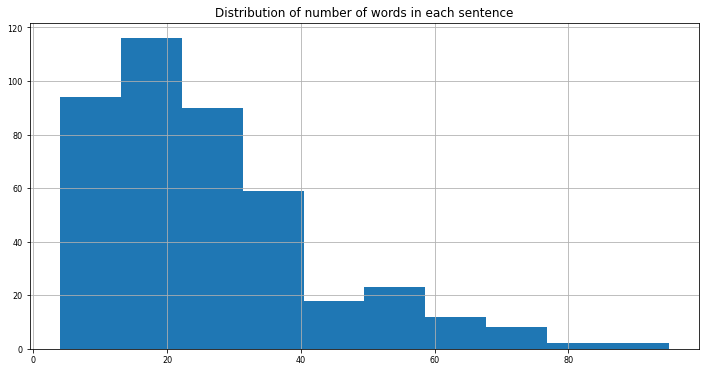

In [4]:
import matplotlib.pyplot as plt
marks_df['NumWords'] = marks_df['Sentence'].apply(lambda x: len(x.split()))
marks_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

In [5]:
all_words = ''.join([word for word in marks_df['Sentence']]).replace('\n', ' ')
all_words[0:1000]

' The history of all hitherto existing societies is the history of class struggles  Freeman and slave, patrician and plebeian, lord and serf, guild-master and journeyman, in a word, oppressor and oppressed, stood in constant opposition to one another, carried on an uninterrupted, now hidden, now open fight, a fight that each time ended, either in a revolutionary re-constitution of society at large, or in the common ruin of the contending classes  In the earlier epochs of history, we find almost everywhere a complicated arrangement of society into various orders, a manifold gradation of social rank In ancient Rome we have patricians, knights, plebeians, slaves; in the Middle Ages, feudal lords, vassals, guild-masters, journeymen, apprentices, serfs; in almost all of these classes, again, subordinate gradations  The modern bourgeois society that has sprouted fcrom the ruins of feudal society has not done away with class antagonisms It has but established new classes, new conditions of op

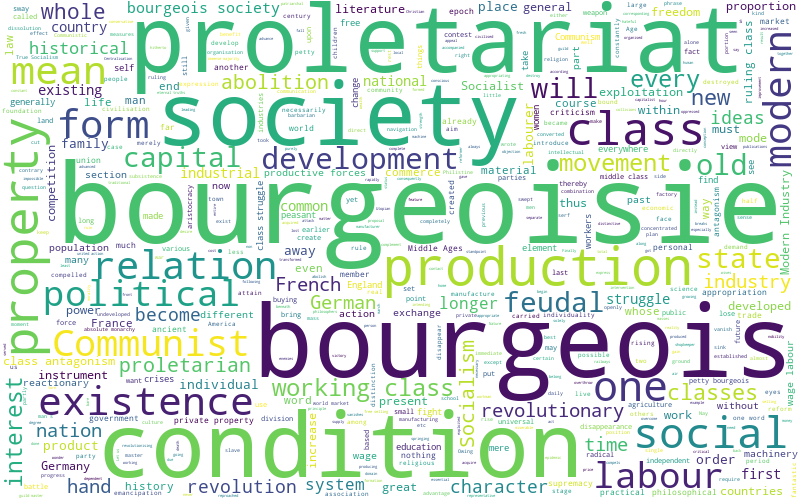

In [6]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_words)

# Visualize the word cloud
wordcloud.to_image()

In [7]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
marks_df['Sentence2'] = marks_df['Sentence'].apply(normalize_texts)
marks_df.head()
marks_df['Sentence2'] = marks_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

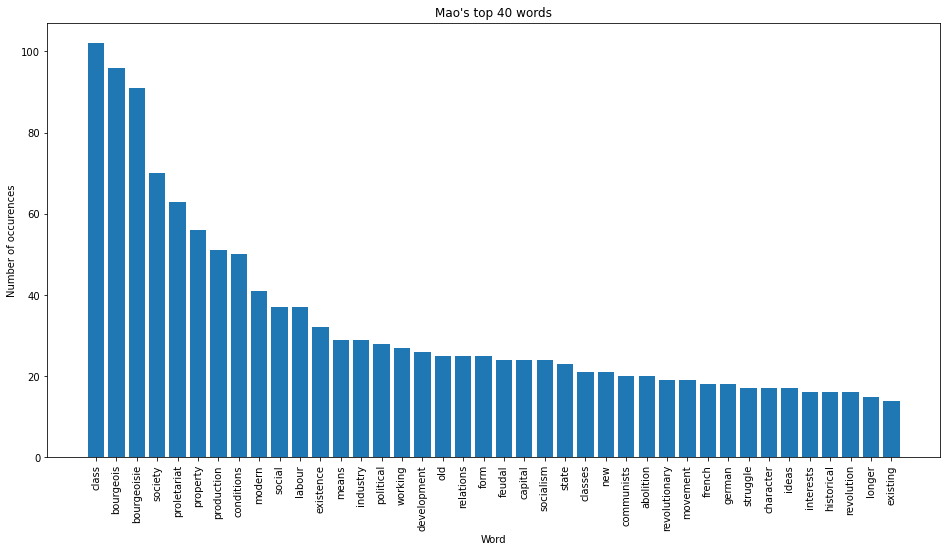

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(marks_df['Sentence2'], 40):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 40 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

# Process `text` with Spacy NLP Parser
text = '. '.join(marks_sentences)
processed_text = nlp(text)

In [10]:
# How many sentences are in the book (Pride & Prejudice)?
sentences = [s for s in processed_text.sents]
print(len(sentences))

# Print sentences from index 10 to index 15, to make sure that we have parsed the correct book
print(sentences[10:15])

589
[ Society as a whole is more and more
splitting up into two great hostile camps, into two great classes,
directly facing each other: Bourgeoisie and Proletariat., 

From the serfs of the Middle Ages sprang the chartered burghers of the
earliest towns.,  From these burgesses the first elements of the
bourgeoisie were developed., 

, The discovery of America, the rounding of the Cape, opened up fresh
ground for the rising bourgeoisie.]


In [11]:
# Extract all the personal names and count their occurrences. 
# Expected output is a list in the following form: [('xxx', 622), ('yyy', 312), ('zzz', 286), ...].

from collections import Counter, defaultdict

def find_character_occurences(doc):
    """
    Return a list of actors from `doc` with corresponding occurences.
    
    :param doc: Spacy NLP parsed document
    :return: list of tuples in form
        [('xxx', 622), ('yyy', 312), ('zzz', 286), ...]
    """
    
    characters = Counter()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            characters[ent.lemma_] += 1
            
    return characters.most_common()

print(find_character_occurences(processed_text)[:20])

[('socialism', 4), ('Socialism', 3), ('feudal socialism', 2), ('serfs', 1), ('Hitherto', 1), ('Christian Socialism', 1), ('Philosophie de la Misère', 1), ('Bourgeois Socialism', 1), ('Saint-Simon', 1), ('Owen', 1), ('Gospel', 1)]


In [12]:
# Plot characters' mentions as a time series relative to the position of the actor's occurrence in a book.

def get_character_offsets(doc):
    """
    For every character in a `doc` collect all the occurences offsets and store them into a list. 
    The function returns a dictionary that has actor lemma as a key and list of occurences as a value for every character.
    
    :param doc: Spacy NLP parsed document
    :return: dict object in form
        [('xxx', 622), ('yyy', 312), ('zzz', 286), ...]
    """
    
    character_offsets = defaultdict(list)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            character_offsets[ent.lemma_].append(ent.start)
            
    return dict(character_offsets)

character_occurences = get_character_offsets(processed_text)

In [13]:
print(list(character_occurences.keys()))

['serfs', 'Hitherto', 'feudal socialism', 'Christian Socialism', 'socialism', 'Socialism', 'Philosophie de la Misère', 'Bourgeois Socialism', 'Saint-Simon', 'Owen', 'Gospel']


In [14]:
[x for x in list(character_occurences.keys()) if any([x.startswith(y) for y in ['Sun Yat', 'Chiang Kai']])]

[]

In [15]:
# Extract Keywords using noun chunks from the news article (file 'article.txt').
# Spacy will pick some noun chunks that are not informative at all (e.g. we, what, who).
# Try to find a way to remove non informative keywords.

#article = read_file('data/article.txt')
#doc = nlp(article)
doc = processed_text

keywords = Counter()
for chunk in doc.noun_chunks:
    if nlp.vocab[chunk.lemma_].prob < - 8: # probablity value -8 is arbitrarily selected threshold
        keywords[chunk.lemma_] += 1

keywords.most_common(30)

[('it', 97),
 ('they', 97),
 ('the bourgeoisie', 53),
 ('production', 38),
 ('the proletariat', 37),
 ('society', 30),
 ('we', 29),
 ('itself', 23),
 ('industry', 18),
 ('capital', 18),
 ('you', 18),
 ('he', 17),
 ('the Communists', 17),
 ('property', 16),
 ('existence', 14),
 ('the condition', 13),
 ('labour', 12),
 ('Germany', 12),
 ('who', 12),
 ('France', 10),
 ('what', 10),
 ('the proletarian', 10),
 ('the bourgeois', 10),
 ('_', 10),
 ('commerce', 9),
 ('the\nbourgeoisie', 8),
 ('exchange', 8),
 ('proportion', 8),
 ('the development', 8),
 ('a class', 8)]

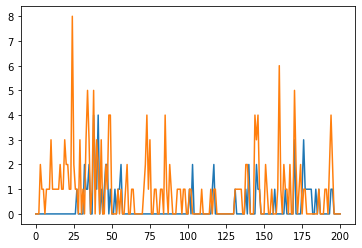

In [16]:
def get_words_paragraphs(paragraphs, words):
    
    word_para = defaultdict(list)
    for p in marks_paragraphs:
        for w in words:
            word_para[w].append(p.count(w))
            
    return dict(word_para)

proletariat_bourgeois_occurences = get_words_paragraphs(marks_paragraphs, ['proletariat', 'bourgeois'])
proletariat_occurences = [v for k,v in proletariat_bourgeois_occurences.items() if k == 'proletariat'][0]
bourgeois_occurences = [v for k,v in proletariat_bourgeois_occurences.items() if k == 'bourgeois'][0]
plt.plot(proletariat_occurences)
plt.plot(bourgeois_occurences)

In [17]:
moral_words = []
with open('mfd2.0.dic', "r") as input:
    pair_lines = input.read().split("\n")
for p in pair_lines:
    moral_words.append(p.split('\t')[0])
print(moral_words[0:30])

['compassion', 'empathy', 'kindness', 'caring', 'generosity', 'benevolence', 'altruism', 'compassionate', 'nurture', 'gentleness', 'nurturance', 'sympathy', 'nurturing', 'motherly', 'love', 'beneficence', 'empathize', 'helpfulness', 'loving', 'pity', 'mercy', 'nurturer', 'compassionately', 'nurturers', 'caringly', 'empathising', 'merciful', 'empathizing', 'nurtures', 'warmhearted']


100%|███████████████████████████████████████| 201/201 [00:00<00:00, 1760.29it/s]


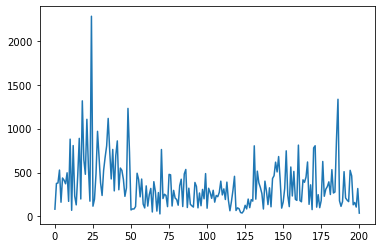

In [18]:
from tqdm import tqdm
def get_any_words_paragraphs(paragraphs, words):
    
    word_para = []
    for p in tqdm(paragraphs):
        total = 0
        for w in words:
            total += p.count(w)
        word_para.append(total)
            
    return word_para

moral_occurences = get_any_words_paragraphs(marks_paragraphs, moral_words)
plt.plot(moral_occurences)

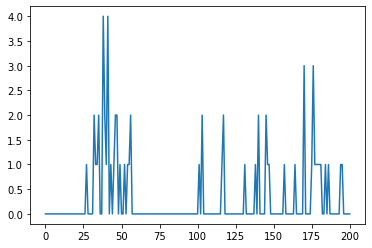

In [19]:
plt.plot(proletariat_occurences)

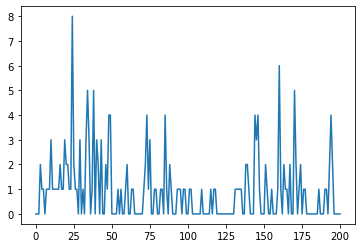

In [20]:
plt.plot(bourgeois_occurences)

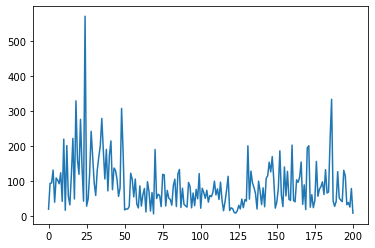

In [21]:
plt.plot([m / 4 for m in  moral_occurences])

In [22]:
bool_proletariat_occurences = [bool(v) for v in proletariat_occurences]
bool_bourgeois_occurences = [bool(v) for v in bourgeois_occurences]

In [23]:
df_moral = pd.DataFrame(list(zip(moral_occurences, bourgeois_occurences, proletariat_occurences)), 
                        columns =['morals', 'bourgeois', 'proletariat'])
df_moral

,morals,bourgeois,proletariat
0,83,0,0
1,376,0,0
2,381,0,0
3,528,2,0
4,162,1,0
...,...,...,...
196,133,0,0
197,159,0,0
198,107,0,0
199,318,0,0


In [24]:
sum(bourgeois_occurences)

184

In [25]:
fml = 'morals ~ bourgeois + proletariat + bourgeois:proletariat'
import pymc3 as pm
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df_moral, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(4000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bourgeois:proletariat, proletariat, bourgeois, Intercept]


/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 7 seconds.


In [26]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [27]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
rvs

['Intercept',
 'bourgeois',
 'proletariat',
 'bourgeois:proletariat',
 'mu',
 'alpha']

In [28]:
def plot_traces(trcs, var_names=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if var_names is not None:
        nrows = len(var_names)

    ax = pm.traceplot(trcs, var_names=var_names, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,var_names=var_names).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, var_names=var_names)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/tq/jmjsbxxn7f9_q8hh0yz05_dm0000gn/T/ipykernel_15064/3101353936.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, var_names=var_names, figsize=(12,nrows*1.4),
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release

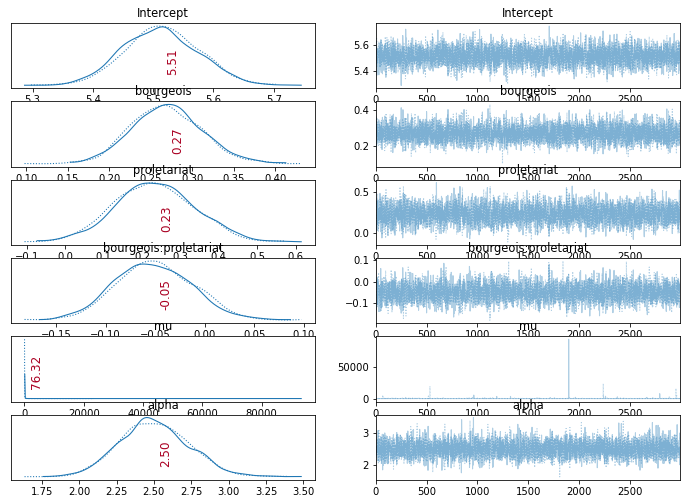

In [29]:
plot_traces(trace[1000:], var_names=rvs);

In [30]:
import numpy as np
# Transform coefficients to recover parameter values
np.exp(pm.summary(trace[1000:], var_names=rvs))

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.478937e+02,1.063962,222.071633,2.792200e+02,1.001001e+00,1.001001,inf,inf,2.718282
bourgeois,1.308655e+00,1.042894,1.212883,1.419068e+00,1.001001e+00,1.000000,inf,inf,2.718282
proletariat,1.263644e+00,1.108491,1.048122,1.541876e+00,1.002002e+00,1.001001,inf,inf,2.718282
bourgeois:proletariat,9.502787e-01,1.039770,0.885148,1.022244e+00,1.001001e+00,1.001001,inf,inf,2.718282
mu,1.391931e+33,inf,1.002002,1.932038e+52,1.641022e+08,644351.716733,inf,inf,2.718282
alpha,1.224356e+01,1.261120,7.822467,1.841195e+01,1.003005e+00,1.002002,inf,inf,2.718282


In [31]:
df_moral2 = pd.DataFrame(list(zip(moral_occurences, bool_bourgeois_occurences, bool_proletariat_occurences)), 
                        columns =['morals', 'bourgeois_p', 'proletariat_p'])
df_moral2


,morals,bourgeois_p,proletariat_p
0,83,False,False
1,376,False,False
2,381,False,False
3,528,True,False
4,162,True,False
...,...,...,...
196,133,False,False
197,159,False,False
198,107,False,False
199,318,False,False


/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


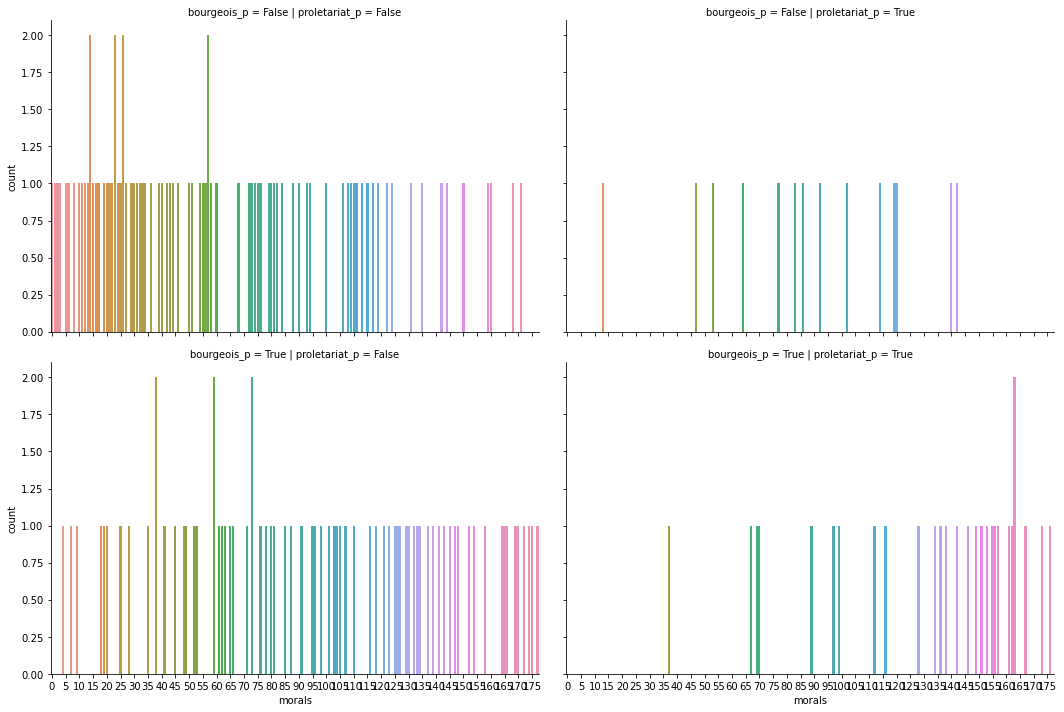

In [32]:
import seaborn as sns
g = sns.factorplot(x='morals', row='bourgeois_p', col='proletariat_p', data=df_moral2, kind='count', aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

In [33]:
df_moral2.groupby(['bourgeois_p', 'proletariat_p'])['morals'].agg(['mean', 'var'])

mean            var
bourgeois_p proletariat_p                           
False       False          241.458824   35885.227451
            True           313.500000   17073.807692
True        False          413.635135  119541.906146
            True           573.642857   76168.015873

In [34]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

fml = 'morals ~ bourgeois_p + proletariat_p + bourgeois_p:proletariat_p'

with pm.Model() as model2:
    pm.glm.GLM.from_formula(formula=fml, data=df_moral2, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(2000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bourgeois_p[T.True]:proletariat_p[T.True], proletariat_p[T.True], bourgeois_p[T.True], Intercept]


/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/var/folders/tq/jmjsbxxn7f9_q8hh0yz05_dm0000gn/T/ipykernel_15064/3101353936.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, var_names=var_names, figsize=(12,nrows*1.4),
Got error No model on context stack. trying to find log_likelihood in translation.


['Intercept', 'bourgeois_p[T.True]', 'proletariat_p[T.True]', 'bourgeois_p[T.True]:proletariat_p[T.True]', 'mu', 'alpha']


/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'I', 'p', 'b', 'a', 'm'} expected from {'Intercept', 'proletariat_p[T.True]', 'mu', 'bourgeois_p[T.True]:proletariat_p[T.True]', 'bourgeois_p[T.True]', 'alpha'}
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be depr

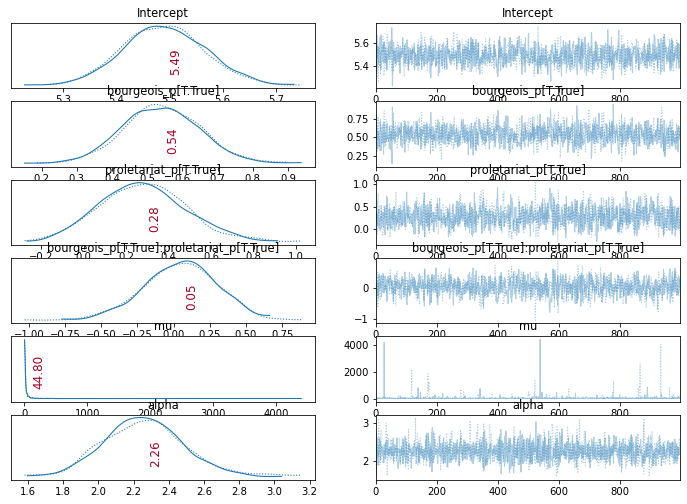

In [36]:
rvs = [rv.name for rv in strip_derived_rvs(model2.unobserved_RVs)]
print(rvs)
plot_traces(trace[1000:], var_names=rvs);

In [37]:
np.exp(pm.summary(trace[500:], var_names=rvs)[['mean','hdi_3%','hdi_97%']])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,hdi_3%,hdi_97%
Intercept,2.420151e+02,210.608298,2.775497e+02
bourgeois_p[T.True],1.717724e+00,1.397940,2.106441e+00
proletariat_p[T.True],1.319166e+00,0.896730,1.902179e+00
bourgeois_p[T.True]:proletariat_p[T.True],1.054430e+00,0.655079,1.647073e+00
mu,1.111231e+18,1.010050,6.243248e+47
alpha,9.602275e+00,6.321775,1.471695e+01
